In [11]:
from datetime import date
import pandas as pd
from cmdty_storage import CmdtyStorage, InjectWithdrawByInventoryAndPeriod, InjectWithdrawByInventory, intrinsic_value


In [12]:
import clr
from pathlib import Path
clr.AddReference(str(Path("cmdty_storage/lib/Cmdty.TimePeriodValueTypes")))
from Cmdty.TimePeriodValueTypes import Day

In [7]:
def _create_piecewise_flat_series(data, dt_index, freq):
    period_index = pd.PeriodIndex([pd.Period(dt, freq=freq) for dt in dt_index])
    return pd.Series(data, period_index).resample(freq).fillna('pad')

In [19]:
        constraints =   [
                            InjectWithdrawByInventoryAndPeriod(date(2019, 8, 28), 
                                        [
                                            InjectWithdrawByInventory(0.0, -150.0, 255.2),
                                            InjectWithdrawByInventory(2000.0, -200.0, 175.0),
                                        ]),
                            (date(2019, 9, 10), 
                                     [
                                         (0.0, -170.5, 235.8),
                                         (700.0, -180.2, 200.77),
                                         (1800.0, -190.5, 174.45),
                                    ])
                ]

        storage_start = date(2019, 8, 28)
        storage_end = date(2019, 9, 25)
        constant_injection_cost = 0.015
        constant_pcnt_consumed_inject = 0.0001
        constant_withdrawal_cost = 0.02
        constant_pcnt_consumed_withdraw = 0.000088
        constant_pcnt_inventory_loss = 0.001;
        constant_pcnt_inventory_cost = 0.002;

        cmdty_storage = CmdtyStorage('D', storage_start, storage_end, constant_injection_cost, constant_withdrawal_cost, constraints, 
                                cmdty_consumed_inject=constant_pcnt_consumed_inject, cmdty_consumed_withdraw=constant_pcnt_consumed_withdraw,
                                inventory_loss=constant_pcnt_inventory_loss, inventory_cost=constant_pcnt_inventory_cost)

        inventory = 650.0
        val_date = date(2019, 9, 2)

        forward_curve = _create_piecewise_flat_series([58.89, 61.41, 59.89, 59.89], [val_date, date(2019, 9, 12), date(2019, 9, 18), storage_end], freq='D')
        
        flat_interest_rate = 0.03
        interest_rate_curve = pd.Series(index = pd.period_range(val_date, storage_end, freq='D'))
        interest_rate_curve[:] = flat_interest_rate

        first_day_rule = lambda period: period.First[Day]()
        intrinsic_results = intrinsic_value(cmdty_storage, val_date, inventory, forward_curve, settlement_rule=first_day_rule, 
                        interest_rates=interest_rate_curve, num_inventory_grid_points=100)

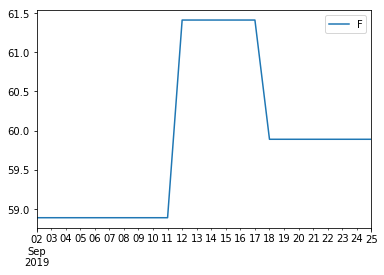

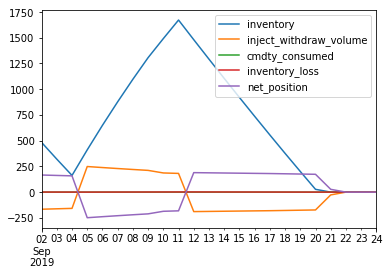

In [28]:
%matplotlib inline
ax = forward_curve.plot(legend=True)
ax.legend("Forward Curve")
intrinsic_results.profile.plot()

In [24]:
intrinsic_results.profile

,inventory,inject_withdraw_volume,cmdty_consumed,inventory_loss,net_position
2019-09-02,483.100000,-166.250000,0.014630,0.650000,166.235370
2019-09-03,320.539400,-162.077500,0.014263,0.483100,162.063237
2019-09-04,162.205376,-158.013485,0.013905,0.320539,157.999580
2019-09-05,410.738735,248.695564,0.024870,0.162205,-248.720434
2019-09-06,649.057373,238.729377,0.023873,0.410739,-238.753250
2019-09-07,877.581115,229.172799,0.022917,0.649057,-229.195717
2019-09-08,1096.712531,220.008997,0.022001,0.877581,-220.030998
2019-09-09,1306.837646,211.221828,0.021122,1.096713,-211.242950
2019-09-10,1491.780838,186.250030,0.018625,1.306838,-186.268655
2019-09-11,1672.113901,181.824844,0.018182,1.491781,-181.843026
